In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

In [2]:
from omegaconf import OmegaConf
import torch
import segmentation_models_pytorch as smp
from torch import nn
from pytorch_lightning.logging import TestTubeLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from dl.lightning_model import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/l

In [3]:
model = smp.FPN(encoder_name="resnext50_32x4d", classes=2, decoder_merge_policy='cat')

criterion = nn.CrossEntropyLoss(
    ignore_index = -100,
    reduction = 'none'
)

In [4]:
conf = OmegaConf.create(
    {   
        'experiment_root_dir':"../../../../results/tests/",
        'dataset':'kumar',
        'model_name':'FPN',
        'experiment_version':'test5',
        'resume_training':True,
        'num_epochs':6,
        'num_gpus':1,
        'n_classes':2,
        'patch_size':224, # input size of the images in the network
        'batch_size':6,
        
        'optimizer_args':{
            'lr':0.001,
            'encoder_lr':0.0005,
            'weight_decay':0.0003,
            'encoder_weight_decay':0.00003
        },
        
        'scheduler_args': {
            'factor':0.25,
            'patience':2
        },
    
        'loss_args' : {
            'edge_weight' : 1.1,
        },
        
        'inference_args' : {
            'smoothen':True
        }

    }
)
print(conf.pretty())

experiment_root_dir: ../../../../results/tests/
dataset: kumar
model_name: FPN
experiment_version: test5
resume_training: true
num_epochs: 6
num_gpus: 1
n_classes: 2
patch_size: 224
batch_size: 6
optimizer_args:
  lr: 0.001
  encoder_lr: 0.0005
  weight_decay: 0.0003
  encoder_weight_decay: 3.0e-05
scheduler_args:
  factor: 0.25
  patience: 2
loss_args:
  edge_weight: 1.1
inference_args:
  smoothen: true



In [5]:
tt_logger = TestTubeLogger(
    save_dir=conf['experiment_root_dir'],
    name=conf['model_name'],
    version=conf['experiment_version']
)

checkpoint_dir = (
    Path(tt_logger.save_dir)
    / tt_logger.experiment.name
    / f"version_{tt_logger.experiment.version}"
    / "checkpoints"
)

checkpoint_callback = ModelCheckpoint(
    filepath = str(checkpoint_dir),
    save_top_k = 1,
    save_last = True,
    verbose = True, 
    monitor = 'avg_val_loss',
    mode = 'min',
    prefix = ''
)

lightning_model = SegModel(
    model=model, 
    criterion = criterion, 
    conf = conf
)

if conf['resume_training']:   
    last_checkpoint_path = (
        Path(tt_logger.save_dir)
        / tt_logger.experiment.name
        / f"version_{tt_logger.experiment.version}"
        / "last.ckpt"
    )
    
    trainer = pl.Trainer(
        default_root_dir=conf['experiment_root_dir'],
        max_epochs=conf['num_epochs'], 
        gpus=conf['num_gpus'],  
        logger=tt_logger,
        checkpoint_callback=checkpoint_callback,
        resume_from_checkpoint=str(last_checkpoint_path)
    )
    
else:
    trainer = pl.Trainer(
        default_root_dir=conf['experiment_root_dir'],
        max_epochs=conf['num_epochs'], 
        gpus=conf['num_gpus'],  
        logger=tt_logger,
        checkpoint_callback=checkpoint_callback,
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [6]:
log_dir = (
    Path(tt_logger.save_dir)
    / tt_logger.experiment.name
    / f"version_{tt_logger.experiment.version}"
    / "tf"
)

In [7]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6007 (pid 10726), started 2:15:45 ago. (Use '!kill 10726' to kill it.)

In [8]:
trainer.fit(lightning_model)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | FPN              | 25 M  
1 | criterion | CrossEntropyLoss | 0     



Epoch 00003: avg_val_loss reached 0.19332 (best 0.19332), saving model to /home/local/leos/Dippa/results/tests/FPN/version_test5/_ckpt_epoch_3.ckpt as top 1



Epoch 00004: avg_val_loss reached 0.19139 (best 0.19139), saving model to /home/local/leos/Dippa/results/tests/FPN/version_test5/_ckpt_epoch_4.ckpt as top 1



Epoch 00005: avg_val_loss reached 0.18320 (best 0.18320), saving model to /home/local/leos/Dippa/results/tests/FPN/version_test5/_ckpt_epoch_5.ckpt as top 1


1

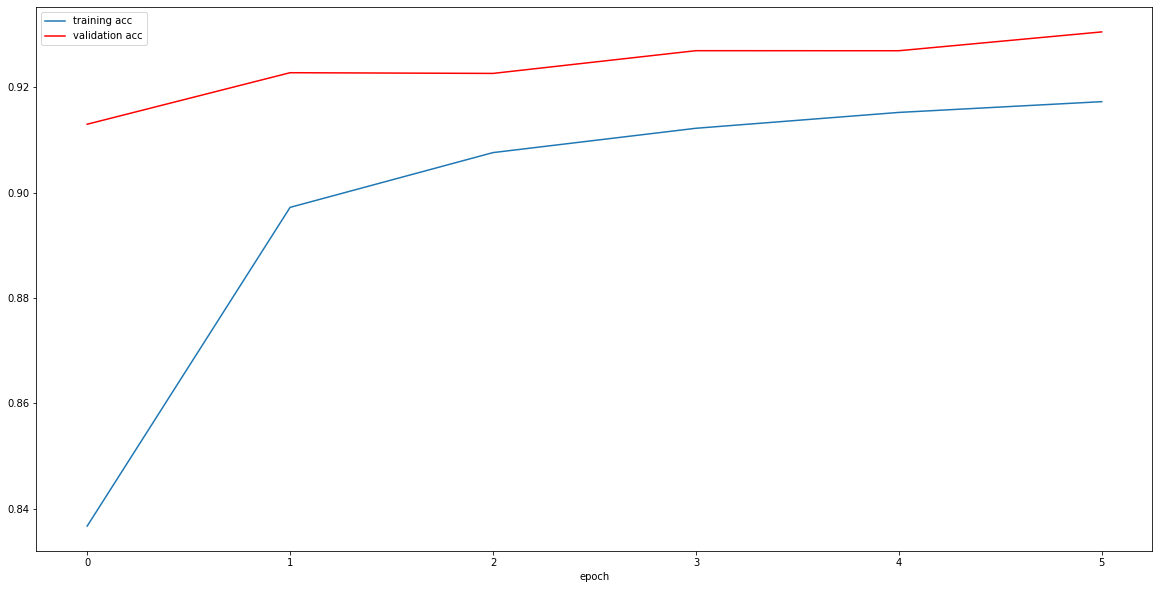

In [9]:
plot_metrics(conf=conf, metric='accuracy', scale='linear')